In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [2]:
from MADLens.util import *

### list all possible run files

In [3]:
run_dir   = '../runs'

githashes = os.listdir(run_dir)
for githash in githashes:
    print(githash)
    path = os.path.join(run_dir,githash)
    print(os.listdir(path))

1458ce7
['myrun0.json']


In [4]:
my_run0 = Run(githash='1458ce7', label='myrun', rnum=0, local_path='../')

my_run0.fill_cl_dicts()

True

In [5]:
mymap=my_run0.get_map(1.0,0)

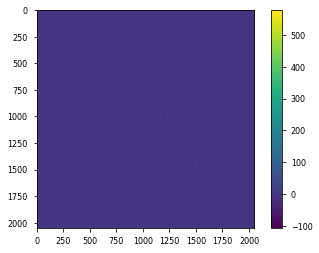

In [6]:
plt.imshow(mymap)
plt.colorbar()

In [10]:
# a function that computes lensing Cells from different Pks (theory, measured from snapshots)

from scipy.interpolate import interp1d
def compute_C_ell_from_Pk(measured_powers,run, L, z_central = False, mode='theory', test_interp=False):
    
    cosmo      = run.cosmo.clone(P_k_max=200,nonlinear=True)
    factor     = 3./2.*cosmo.Omega0_m*(cosmo.H0/cosmo.C)**2
    nbar       = run.nbar
    chi_source = cosmo.comoving_distance(run.z_source)
    shotnoise  = 1./nbar
    def W_lens(chis,chimax):
        return chis*(chimax-chis)/chimax
    
    L          = np.logspace(np.log10(min(L)),np.log10(max(L)),200)
    CL=[]
    CL2=[]
    

    for LL in L:
        chis=[]
        integrand=[]
        #always use same redshifts, also when computing from theory Pk
        for ii, (key, value) in enumerate(measured_powers.items()):
            # we can look at central or final redshift of the snapshot, PGD is calibrated with respect to final redshift, but is that what we want for lensing?
            zf   = float(key)
 
            z= zf
            # Pk is measured at zf
            Pk   = value['power'][1::]
            k    = value['k'][1::]
            # shotnoise (seems to be zero in attrs...)
            shn  = 1./nbar
            
            if LL==L[0] and ii==0:
                print('shotnoise',shn)
            
            #again, should we use zf or zc here? does it matter?
            chi  = cosmo.comoving_distance(z)
            
            if chi==0:
                chi=1e-2
                
            k_   = LL/chi
            
            if mode=='theory':
                try:
                    Pk_  = cosmo.get_pk(k_,z)
                except:
                    Pk_  = 0.
                    
            if mode=='measured extrapolated+ shotnoise':
                # take measured power spectrum and use estimate of shotnoise as extrapolation value if shotnoise is bigger than extrapolated value
                Pki= interp1d(np.log(k),np.log(Pk-shotnoise),kind='linear',bounds_error=False, fill_value=0.)
                Pk_= np.exp(Pki(np.log(k_)))+shotnoise
                if k_>max(k):
                    Pk_=np.exp(Pki(np.log(max(k))))*(k_/max(k))**(-2)+shn
                if Pk_<shn:
                    Pk_=shn
            if mode=='measured no extrapolation':
                # simply extrapolate measured power spectrum (no shot noise addition)
                Pki= interp1d(np.log(k),np.log(Pk),kind='linear',bounds_error=False, fill_value=0.)
                Pk_= np.exp(Pki(np.log(k_)))
            if test_interp:
                if LL ==L[0]:
                    #do some test plots to check if inter/extrapolation works correctly
                    if mode=='measured':
                        plt.figure()
                        plt.title('z=%.2f'%float(key))
                        kk=(L/chi)
                        kk= kk[np.where((kk>0)*(kk<100))]
                        plt.loglog(kk,cosmo.get_pk(kk,z),label='halofit')
                        plt.loglog(k,Pk,label='measured')
                        plt.loglog(kk,np.exp(Pki(np.log(kk))),ls='--',label='measured interp+extrapolated')
                        plt.axhline(shn,color='green',ls='-.',label='shotnoise level')
                        plt.axvline(max(k),color='crimson',ls=':',label='kmax')
                        plt.xlabel('k')
                        plt.ylabel('P(k)')
                        plt.legend()
                        plt.show()
                    # transfer function with respect to Pk at zc and zf - no big difference without PGD, big difference with!   
                    if mode=='measured':
                        plt.figure()
                        plt.title('transfer at z=%.2f'%float(key))
                        plt.semilogx(k[1::],Pk[1::]/cosmo.get_pk(k[1::],zf),label='ratio to Pk at zfinal')
                        plt.semilogx(k[1::],Pk[1::]/cosmo.get_pk(k[1::],zc),label='ratio to Pk at zcentral')
                        plt.xlabel('k')
                        plt.ylabel('P(k)')
                        plt.legend()
                        plt.show()
            # again, use zf here
            integrand+=[Pk_*(W_lens(chi,chi_source)/chi*(1+z))**2]
            chis+=[chi]
        chis_=chis+[chi_source]
        integrand=np.asarray(integrand)
        chis     =np.asarray(chis)
        chis_    =np.asarray(chis_)
        dchis    =np.diff(chis_)
        #CL+=[np.trapz(y=integrand,x=chis)]
        CL+=[np.sum(integrand*dchis)]
        
    result =np.asarray(CL)*factor**2
    #result2=np.asarray(CL2)*factor**2
    return L, result#, result2